In [1]:
!pip install spacy
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 131.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install transformers pandas tqdm

  Using cached tokenizers-0.20.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.7 kB)
Using cached tokenizers-0.20.3-cp311-cp311-macosx_11_0_arm64.whl (2.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-upstage 0.6.0 requires tokenizers<0.20.0,>=0.19.1, but you have tokenizers 0.20.3 which is incompatible.
langchain-chroma 0.2.0 requires numpy<2.0.0,>=1.22.4; python_version < "3.12", but you have numpy 2.2.6 which is incompatible.


In [1]:
import spacy
import pandas as pd
import random

with open("20k_sentences_with_negation.txt", "r") as f:
    sentences = [line.strip() for line in f if line.strip()]

nlp = spacy.load("en_core_web_sm")

nouns, verbs, adjectives = set(), set(), set()

for sent in sentences:
    doc = nlp(sent)
    for token in doc:
        if token.pos_ == "NOUN":
            nouns.add(token.lemma_)
        elif token.pos_ == "VERB":
            verbs.add(token.lemma_)

print(f"Extracted {len(nouns)} nouns, {len(verbs)} verbs")

Extracted 100 nouns, 99 verbs


In [3]:
nouns = sorted([n for n in nouns if n.isalpha() and len(n) > 2])
verbs = sorted([v for v in verbs if v.isalpha() and len(v) > 2])
names = ["John", "Mary", "Alex", "David", "Sarah"]
# adjectives = sorted([a for a in adjectives if a.isalpha() and len(a) > 2])

templates = {
    "simple": "A {subj} didn’t {verb} any {obj}.",
    "rel_clause": "The {subj} that {name} saw didn’t {verb} any {obj}.",
    "adv_clause": "After the incident, a {subj} didn’t {verb} any {obj}.",
    "complex": "Although it was late, a {subj} didn’t {verb} any {obj}."
}

def generate_augmented(n):

    data = []
    for _ in range(n):

        subj = random.choice(nouns)
        obj = random.choice(nouns)
        if subj == obj:
            continue

        verb = random.choice(verbs)
        # adj = random.choice(adjectives)
        name = random.choice(names)

        for key, temp in templates.items():
            sentence = temp.format(subj = subj, verb = verb, obj = obj, name = name) # adj = adj
            data.append({"template": key, "sentence": sentence})

    return pd.DataFrame(data)

df_augmented = generate_augmented(1000)
df_augmented.to_csv("augmented_any_sentences.csv", index=False)

In [4]:
df_augmented

,template,sentence
0,simple,A site didn’t shape any office.
1,rel_clause,The site that Sarah saw didn’t shape any office.
2,adv_clause,"After the incident, a site didn’t shape any of..."
3,complex,"Although it was late, a site didn’t shape any ..."
4,simple,A wife didn’t host any production.
...,...,...
3967,complex,"Although it was late, a community didn’t thank..."
3968,simple,A division didn’t purchase any heart.
3969,rel_clause,The division that David saw didn’t purchase an...
3970,adv_clause,"After the incident, a division didn’t purchase..."


In [5]:
df_augmented = df_augmented.drop_duplicates(subset="sentence").copy()
print("Unique sentences:", len(df_augmented))

Unique sentences: 3969


In [6]:
import openai
import pandas as pd
from tqdm import tqdm

openai.api_key = "SECRET_KEY"

def gpt4o_logprob_score(sentence):
    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "user", "content": f"Please return the total log probability of the following sentence:\n\n\"{sentence}\""},
            ],
            temperature=0,
            max_tokens=1,
            logprobs=True,  # logprob 기반 scoring
        )
        # token 단위 scoring을 유사하게 측정하거나 proxy로 사용할 수 있음
        return response.choices[0].logprobs

    except Exception as e:
        print(f"Error on sentence: {sentence}")
        return None

df_augmented["gpt4o_score"] = [gpt4o_logprob_score(s) for s in tqdm(df_augmented["sentence"])]

100%|██████████| 3969/3969 [46:17<00:00,  1.43it/s]


In [8]:
df_augmented.to_csv("df_augmented.csv", index=False)

In [27]:
df_inter = pd.read_csv("./df_augmented.csv")
df_inter["gpt4o_score"].head(10)

,gpt4o_score
0,ChoiceLogprobs(content=[ChatCompletionTokenLog...
1,ChoiceLogprobs(content=[ChatCompletionTokenLog...
2,ChoiceLogprobs(content=[ChatCompletionTokenLog...
3,ChoiceLogprobs(content=[ChatCompletionTokenLog...
4,ChoiceLogprobs(content=[ChatCompletionTokenLog...
5,ChoiceLogprobs(content=[ChatCompletionTokenLog...
6,ChoiceLogprobs(content=[ChatCompletionTokenLog...
7,ChoiceLogprobs(content=[ChatCompletionTokenLog...
8,ChoiceLogprobs(content=[ChatCompletionTokenLog...
9,ChoiceLogprobs(content=[ChatCompletionTokenLog...


In [31]:
import re

def extract_logprob_from_string(s):
    try:
        match = re.search(r"logprob=(-?\d+\.\d+)", s)
        if match:
            return float(match.group(1))
        else:
            return None
    except:
        return None

df_inter["score_numeric"] = df_inter["gpt4o_score"].apply(extract_logprob_from_string)

df_valid = df_inter.dropna(subset=["score_numeric"])
df_valid["score_numeric"] = pd.to_numeric(df_valid["score_numeric"])

k = 500
df_topk = df_valid.groupby("template", group_keys=False).apply(lambda x: x.nlargest(k, "score_numeric"))

df_topk.head()

<ipython-input-31-14f89ffdd7fc>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_topk = df_valid.groupby("template", group_keys=False).apply(lambda x: x.nlargest(k, "score_numeric"))


,template,sentence,gpt4o_score,score_numeric
2982,adv_clause,"After the incident, a area didn’t earn any thing.",ChoiceLogprobs(content=[ChatCompletionTokenLog...,-0.139573
2030,adv_clause,"After the incident, a air didn’t provide any r...",ChoiceLogprobs(content=[ChatCompletionTokenLog...,-0.152265
2226,adv_clause,"After the incident, a age didn’t paint any use.",ChoiceLogprobs(content=[ChatCompletionTokenLog...,-0.184746
2342,adv_clause,"After the incident, a office didn’t open any s...",ChoiceLogprobs(content=[ChatCompletionTokenLog...,-0.196822
134,adv_clause,"After the incident, a director didn’t attend a...",ChoiceLogprobs(content=[ChatCompletionTokenLog...,-0.207854


In [32]:
df_topk.to_csv("filtered_natural_sentences.csv", index=False)

In [33]:
import torch
from transformers import BertTokenizer, BertForMaskedLM, GPT2Tokenizer, GPT2LMHeadModel

# BERT
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForMaskedLM.from_pretrained("bert-base-uncased")
bert_model.eval()

# GPT-2
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [34]:
def bert_score(sentence):

    masked = sentence.replace(" any ", " [MASK] ")
    inputs = bert_tokenizer(masked, return_tensors="pt")

    mask_index = torch.where(inputs.input_ids == bert_tokenizer.mask_token_id)[1]

    with torch.no_grad():
        outputs = bert_model(**inputs)
    logits = outputs.logits[0, mask_index, :]

    prob = torch.softmax(logits, dim = -1)[0, bert_tokenizer.convert_tokens_to_ids("any")].item()

    return prob

def gpt2_perplexity_diff(sentence):

    ids_with = gpt2_tokenizer(sentence, return_tensors="pt").input_ids

    with torch.no_grad():
        loss_with = gpt2_model(ids_with, labels=ids_with).loss.item()

    sentence_wo_any = sentence.replace(" any", "")
    ids_without = gpt2_tokenizer(sentence_wo_any, return_tensors="pt").input_ids

    with torch.no_grad():
        loss_without = gpt2_model(ids_without, labels=ids_without).loss.item()

    return loss_with - loss_without

In [37]:
from tqdm import tqdm

bert_probs = []
gpt2_diffs = []

for s in tqdm(df_topk["sentence"], desc="score_numeric"):
    bert_probs.append(bert_score(s))
    gpt2_diffs.append(gpt2_perplexity_diff(s))

df_topk["bert_prob_any"] = bert_probs
df_topk["gpt2_perplexity_diff"] = gpt2_diffs
df_topk.to_csv("npi_syntax_results.csv", index=False)

score_numeric: 100%|██████████| 2000/2000 [04:15<00:00,  7.83it/s]


In [21]:
df_final = pd.read_csv("./npi_syntax_results.csv")

<ipython-input-22-7f58a459e155>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x="template", y="bert_prob_any", palette="Greens")


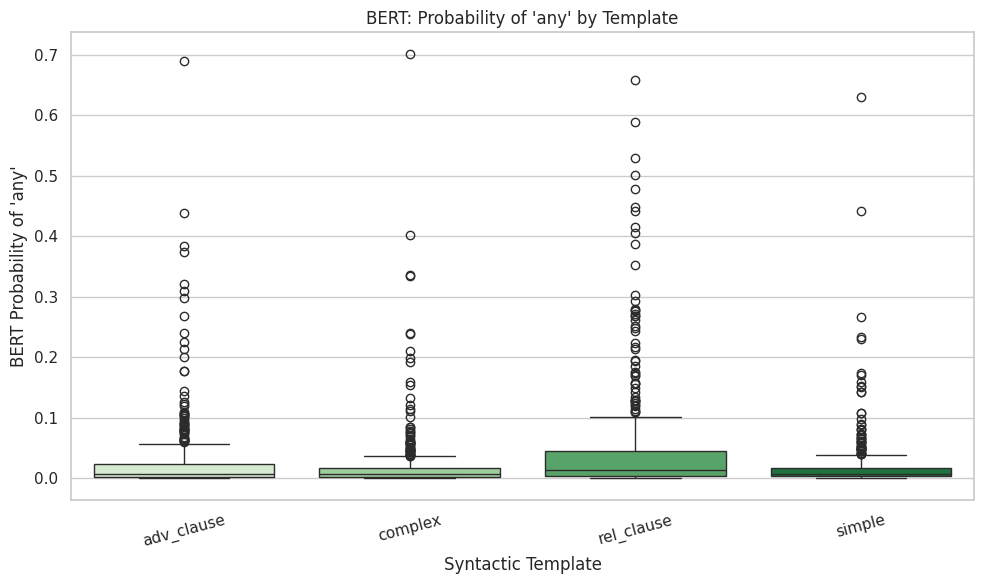

<ipython-input-22-7f58a459e155>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x="template", y="gpt2_perplexity_diff", palette="Greens")


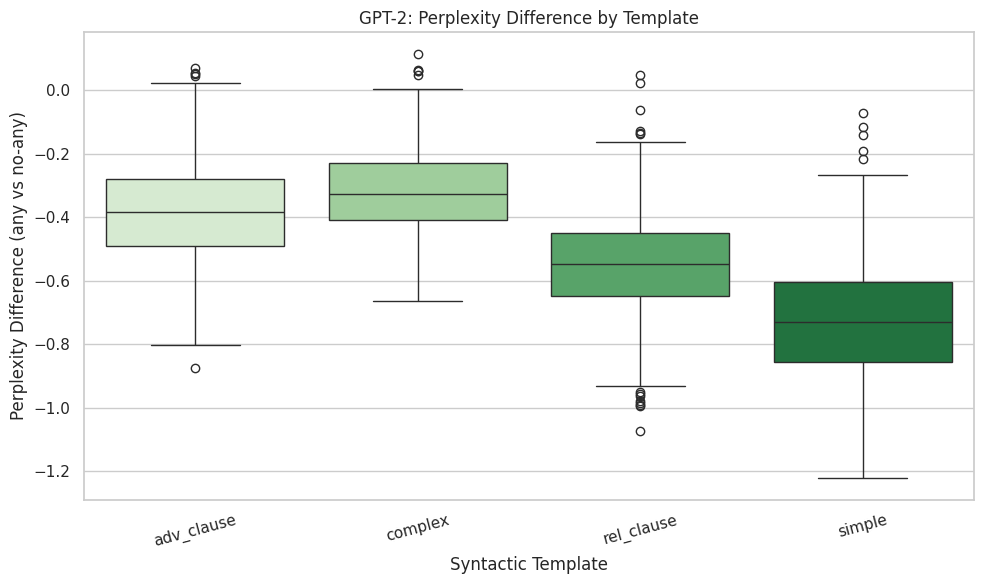

<ipython-input-22-7f58a459e155>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x="template", y="score_numeric", palette="Greens")


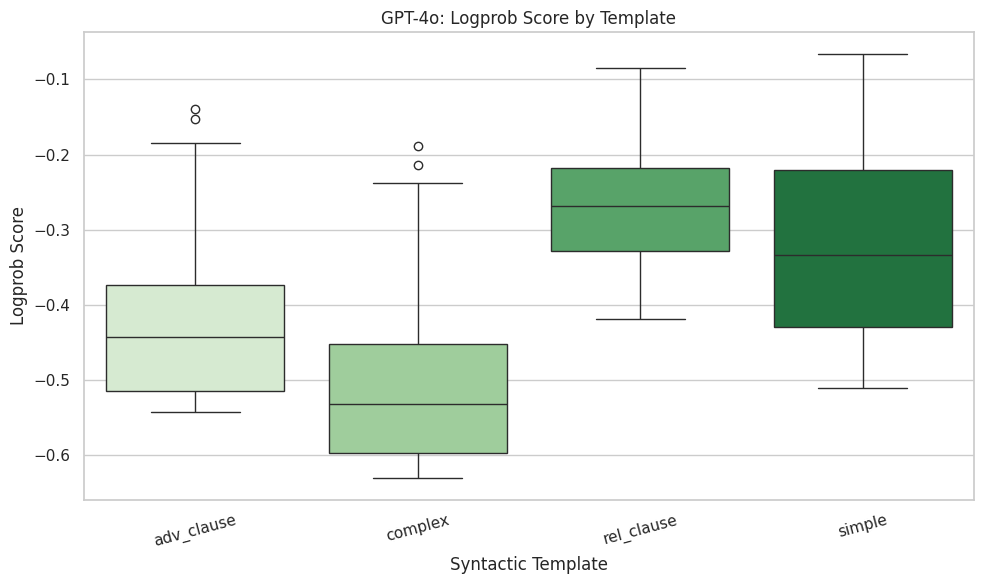

(     template  bert_prob_any_mean  bert_prob_any_std  bert_prob_any_count  \
 0  adv_clause            0.025604           0.058574                  500   
 1     complex            0.018996           0.049740                  500   
 2  rel_clause            0.044283           0.084670                  500   
 3      simple            0.019062           0.044661                  500   
 
    gpt2_perplexity_diff_mean  gpt2_perplexity_diff_std  \
 0                  -0.383971                  0.154513   
 1                  -0.320751                  0.136554   
 2                  -0.547324                  0.165959   
 3                  -0.728981                  0.192920   
 
    gpt2_perplexity_diff_count  score_numeric_mean  score_numeric_std  \
 0                         500           -0.432708           0.086237   
 1                         500           -0.512579           0.096902   
 2                         500           -0.277462           0.073012   
 3                 

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

sns.set(style="whitegrid")

# 1. BERT probability of 'any'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x="template", y="bert_prob_any", palette="Greens")
plt.title("BERT: Probability of 'any' by Template")
plt.ylabel("BERT Probability of 'any'")
plt.xlabel("Syntactic Template")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 2. GPT-2 perplexity difference
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x="template", y="gpt2_perplexity_diff", palette="Greens")
plt.title("GPT-2: Perplexity Difference by Template")
plt.ylabel("Perplexity Difference (any vs no-any)")
plt.xlabel("Syntactic Template")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 3. GPT-4o logprob score
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x="template", y="score_numeric", palette="Greens")
plt.title("GPT-4o: Logprob Score by Template")
plt.ylabel("Logprob Score")
plt.xlabel("Syntactic Template")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

summary_stats = df_final.groupby("template")[["bert_prob_any", "gpt2_perplexity_diff", "score_numeric"]].agg(["mean", "std", "count"])
summary_stats.columns = ["_".join(col) for col in summary_stats.columns]
summary_stats.reset_index(inplace=True)

# ANOVA
anova_bert = f_oneway(*[group["bert_prob_any"].values for _, group in df_final.groupby("template")])
anova_gpt2 = f_oneway(*[group["gpt2_perplexity_diff"].values for _, group in df_final.groupby("template")])
anova_gpt4o = f_oneway(*[group["score_numeric"].values for _, group in df_final.groupby("template")])

anova_results = {
    "BERT ANOVA p-value": anova_bert.pvalue,
    "GPT-2 ANOVA p-value": anova_gpt2.pvalue,
    "GPT-4o ANOVA p-value": anova_gpt4o.pvalue
}

summary_stats, anova_results

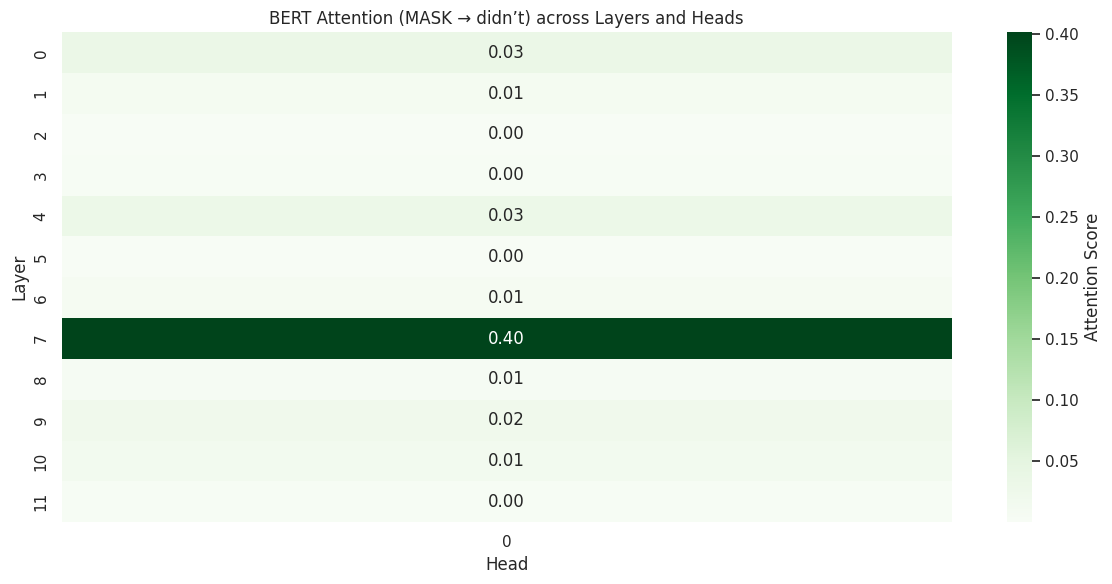

In [23]:
# BERT의 특정 layer/head가 any - didn't와 같은 NPI licensing 요소에 얼마나 집중하는지를 분석
# sentence → 마스킹된 상태 입력
# attention 행렬 추출: shape = [layers x heads x tokens x tokens]
# MASK 위치에서 licensing cue로 attention이 얼마나 분포되는지 측정

from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
model.eval()

# sample sentence
sentence = "The man that John saw didn’t kill any people."
masked = sentence.replace(" any ", " [MASK] ")
inputs = tokenizer(masked, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

mask_idx = tokens.index("[MASK]")
didnt_idx = next(i for i, t in enumerate(tokens) if t.startswith("didn"))

with torch.no_grad():
    outputs = model(**inputs)
attentions = torch.stack(outputs.attentions)  # shape: [layers, heads, batch, from, to]

scores = attentions[:, :, 0, mask_idx, didnt_idx].numpy()  # [layer, head]

plt.figure(figsize=(12, 6))
sns.heatmap(scores, annot=True, fmt=".2f", cmap = "Greens", cbar_kws={'label': 'Attention Score'})
plt.title("BERT Attention (MASK → didn’t) across Layers and Heads")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

In [28]:
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.82.1
    Uninstalling openai-1.82.1:
      Successfully uninstalled openai-1.82.1


In [1]:
# Which of the following sentences is more natural?
# 1. A man didn't open any doors.
# 2. A man opened any doors.

# Respond with '1' or '2' only.

import openai
import pandas as pd
from tqdm import tqdm

openai.api_key = "SECRET_KEY"

def compare_with_gpt4o(sent1, sent2):
    prompt = f"""Which of the following sentences is more natural?
1. {sent1}
2. {sent2}

Respond with '1' or '2' only."""

    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    return response.choices[0].message["content"].strip()

# Example dataframe
df_pairs = pd.DataFrame({
    "sentence1": ["A man didn’t open any doors.", "A man didn’t see any books."],
    "sentence2": ["A man opened any doors.", "A man saw any books."]
})

df_pairs["gpt4o_preference"] = [
    compare_with_gpt4o(row.sentence1, row.sentence2) for _, row in tqdm(df_pairs.iterrows(), total=len(df_pairs))
]


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


In [2]:
df_pairs

,sentence1,sentence2,gpt4o_preference
0,A man didn’t open any doors.,A man opened any doors.,1
1,A man didn’t see any books.,A man saw any books.,1
